In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics 

In [2]:
# convert an array of values into a dataset matrix
#split a univariate sequence into samples/dataset
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        #gather input and output parts of the pattern
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)


In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)


In [4]:
df= pandas.read_excel('D:\8th sem\Covid-19-dataset-for-Bangladesh(recovery).xlsx',usecols=[1])

In [5]:
df.isna().sum()

Recovery per day    3
dtype: int64

In [6]:
df.isna()

,Recovery per day
0,False
1,False
2,False
3,False
4,False
...,...
506,False
507,False
508,False
509,False


In [8]:
missin_idx=df[df['Recovery per day'].isnull()].index.tolist()
#missin_idx=df.isnull().index.tolist()
missin_idx

[29, 56, 99]

In [10]:
for midx in missin_idx:
    df['Recovery per day'][midx] = numpy.mean(df['Recovery per day'][midx-4:midx+4])

In [11]:
df.shape

(511, 1)

In [12]:
df.isna().sum()

Recovery per day    0
dtype: int64

In [13]:
#df['Date'] = pandas.to_numeric(pandas.to_datetime(df['Date']))
dataset=df.values
dataset = dataset.astype('float32')

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [18]:
# split into train and test sets
train_size = int(len(dataset) * 0.701)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

358 153


In [19]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [20]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [21]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
356/356 - 1s - loss: 0.0048
Epoch 2/100
356/356 - 1s - loss: 0.0035
Epoch 3/100
356/356 - 1s - loss: 0.0027
Epoch 4/100
356/356 - 1s - loss: 0.0021
Epoch 5/100
356/356 - 1s - loss: 0.0018
Epoch 6/100
356/356 - 1s - loss: 0.0017
Epoch 7/100
356/356 - 1s - loss: 0.0017
Epoch 8/100
356/356 - 1s - loss: 0.0017
Epoch 9/100
356/356 - 1s - loss: 0.0017
Epoch 10/100
356/356 - 1s - loss: 0.0017
Epoch 11/100
356/356 - 1s - loss: 0.0017
Epoch 12/100
356/356 - 1s - loss: 0.0017
Epoch 13/100
356/356 - 1s - loss: 0.0017
Epoch 14/100
356/356 - 1s - loss: 0.0017
Epoch 15/100
356/356 - 1s - loss: 0.0017
Epoch 16/100
356/356 - 1s - loss: 0.0017
Epoch 17/100
356/356 - 1s - loss: 0.0016
Epoch 18/100
356/356 - 1s - loss: 0.0017
Epoch 19/100
356/356 - 1s - loss: 0.0017
Epoch 20/100
356/356 - 1s - loss: 0.0017
Epoch 21/100
356/356 - 1s - loss: 0.0016
Epoch 22/100
356/356 - 1s - loss: 0.0017
Epoch 23/100
356/356 - 1s - loss: 0.0016
Epoch 24/100
356/356 - 1s - loss: 0.0016
Epoch 25/100
356/356 - 1s

In [22]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [23]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [24]:
# calculate root mean squared error
trainScore = math.sqrt(metrics.mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(metrics.mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 537.97 RMSE
Test Score: 2431.15 RMSE


In [25]:
# calculate mean squared error
trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MSE' % (trainScore))
testScore = metrics.mean_squared_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MSE' % (testScore))

Train Score: 289407.27 MSE
Test Score: 5910474.73 MSE


In [26]:
# calculate mean absolute error
trainScore = metrics.mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = metrics.mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))

Train Score: 297.67 MAE
Test Score: 1280.24 MAE


In [27]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [28]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

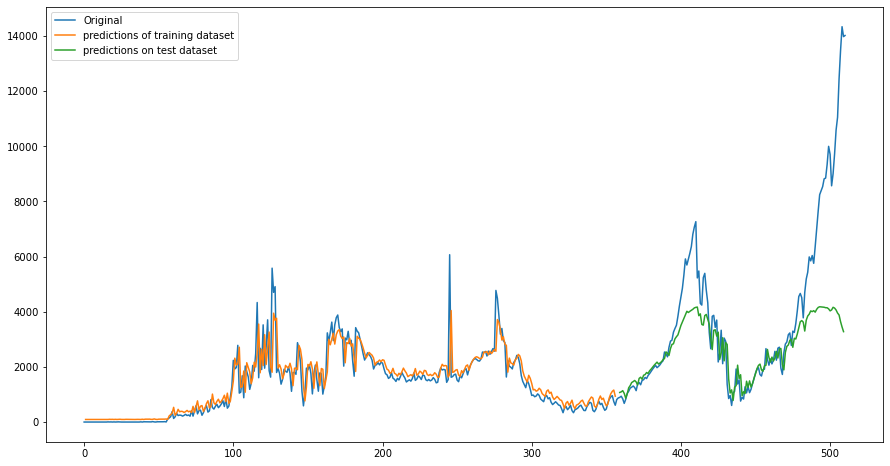

In [29]:
# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(dataset))#original-blue
plt.plot(trainPredictPlot)#orange
plt.plot(testPredictPlot)#green
plt.legend(['Original','predictions of training dataset','predictions on test dataset'])
plt.show()

In [30]:
yhat = model.predict(testX, verbose=0)

In [31]:
for i in range(len(testX)):
    print("Predicted=%s" % (yhat[i]*1000))

Predicted=[74.83018]
Predicted=[76.353325]
Predicted=[79.3823]
Predicted=[72.49804]
Predicted=[60.260815]
Predicted=[71.10699]
Predicted=[86.57116]
Predicted=[92.16961]
Predicted=[99.86482]
Predicted=[102.235344]
Predicted=[105.12535]
Predicted=[101.42442]
Predicted=[93.625145]
Predicted=[110.30474]
Predicted=[113.38639]
Predicted=[108.123375]
Predicted=[118.43537]
Predicted=[119.97253]
Predicted=[125.29178]
Predicted=[122.70729]
Predicted=[129.59042]
Predicted=[133.70335]
Predicted=[138.59535]
Predicted=[143.34071]
Predicted=[147.42256]
Predicted=[151.55269]
Predicted=[146.61143]
Predicted=[149.38153]
Predicted=[152.68764]
Predicted=[157.45172]
Predicted=[160.59254]
Predicted=[177.42558]
Predicted=[174.06444]
Predicted=[168.38776]
Predicted=[185.72368]
Predicted=[196.26283]
Predicted=[197.93352]
Predicted=[210.30197]
Predicted=[215.76245]
Predicted=[220.4272]
Predicted=[232.21893]
Predicted=[244.23776]
Predicted=[253.00229]
Predicted=[261.16403]
Predicted=[271.06052]
Predicted=[280.15